In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator, SymmetricalLogLocator
from matplotlib.ticker import LogFormatterSciNotation, LogFormatter
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, SymLogNorm
import os
import sys
from datetime import timedelta, date
import csv
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
mpl.rcParams['figure.dpi'] = 175

In [3]:
import seaborn as sns
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#FF657A"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings-in-python/49955617#49955617
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()

In [4]:
conn = sqlite3.connect("../agg-data/agg_fcc.db")
df = pd.read_sql_query("select * from agg_httpgetmt;", conn)
conn.close()
#df

In [5]:
conn_unit_profile = sqlite3.connect("../agg-data/unit-profile.db")
df_tech = pd.read_sql_query('select * from "unit-profile"', conn_unit_profile)
conn_unit_profile.close()

#fix AT&T IPBB
df_tech['technology'] = np.where(df_tech.isp == 'AT&T IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'UVERSE', 'DSL', df_tech.technology)

def isp_names(df, column):
    df[column] = np.where(df[column].str.startswith("Verizon"), 'Verizon', df[column])
    df[column] = np.where(df[column] == "TimeWarner", 'Time Warner Cable', df[column])

    df[column] = np.where(df[column].str.startswith("Frontier"), 'Frontier', df[column])
    df[column] = np.where(df[column] == "Qwest", 'CenturyLink', df[column])
    df[column] = np.where(df[column].str.startswith("Cincinnati Bell"), 'Cincinnati Bell', df[column])
    df[column] = np.where(df[column].str.startswith("AT&T"), 'AT&T', df[column])
    df[column] = np.where(df[column] == "TWC", 'Time Warner Cable', df[column])
    
isp_names(df_tech, 'isp')

In [95]:
conn_loc = sqlite3.connect("../agg-data/location-data-2018-2019.db")
df_loc = pd.read_sql_query('select * from "locations"', conn_loc)
conn_loc.close()

conn_loc_carry_forward = sqlite3.connect("../agg-data/location-data-older.db")
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2018;", conn_loc_carry_forward)
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2018;", conn_loc_carry_forward)
df_tmp['year'] = '2019'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2016;", conn_loc_carry_forward)
df_tmp['year'] = '2018'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
df_tmp = pd.read_sql_query("select unitid as unit_id, cast(longitude as float) as longitude, cast(latitude as float) as latitude from locations2016;", conn_loc_carry_forward)
df_tmp['year'] = '2019'
df_loc = pd.concat([df_loc, df_tmp], ignore_index=True)
conn_loc_carry_forward.close()

In [8]:
df = df[df.sum_suc > 0]
df = df[df.med_bytes_sec > 0.]
df['dtime'] = pd.to_datetime(df['dtime'])
df['year'] = df['dtime'].dt.strftime('%Y')
df['date'] = df['dtime'].dt.strftime('%m-%d')
df['med_bytes_sec'] = df['med_bytes_sec'] * 8 / (1000*1000)
df_agg = df.groupby(['unit_id', 'year']).agg({'med_bytes_sec':'median'}).reset_index()



In [108]:
df_plt = pd.merge(df_agg, df_loc, how='inner', on=['unit_id', 'year'])


In [10]:
def custom_general_format(num):
    if num == 0.5:
        return r'$<%s$' % format(num, 'g')
    return format(num, 'g')

In [107]:
df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]
df_satellite_isps = df_satellite_isps[~df_satellite_isps.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
usable_sat_units = df_satellite_isps.unit_id.unique().tolist()
usable_sat_units.remove(1273)
usable_sat_units.remove(801252)
usable_sat_units.remove(13236)
usable_sat_units.remove(999051)
usable_sat_units.remove(216686)

df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]
att_probes_carry_fwd = df_att.unit_id.unique().tolist()
att_probes_carry_fwd.remove(507)
att_probes_carry_fwd.remove(5655)
att_probes_carry_fwd.remove(7460)
att_probes_carry_fwd.remove(27738)
att_probes_carry_fwd.remove(216054)
att_probes_carry_fwd.remove(216146)
att_probes_carry_fwd.remove(805166)
att_probes_carry_fwd.remove(805490)
att_probes_carry_fwd.remove(805630)
att_probes_carry_fwd.remove(805782)
att_probes_carry_fwd.remove(811954)
att_probes_carry_fwd.remove(941780)
att_probes_carry_fwd.remove(994195)
att_probes_carry_fwd.remove(994419)
att_probes_carry_fwd.remove(999719)

#Hawaiian Telcom -- remove, bought by cincinnati bell
df_hitel = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hawaiian Telcom']))]
df_hitel = df_hitel[~df_hitel.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
hit_probes_carry_fwd = df_hitel.unit_id.unique().tolist()
hit_probes_carry_fwd.remove(995125)
hit_probes_carry_fwd.remove(995121)
hit_probes_carry_fwd = []

df_tech_for_merge = pd.DataFrame()
for year in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    #print(year)
    if year == '2012':
        df_tmp = df_tech[df_tech.year == '2012']
        df_tmp_for_append = df_tmp[df_tmp.month == '09']
        list_2012_newer_units = df_tmp_for_append.unit_id.to_list()
        list_2012_older_units = df_tmp[df_tmp.month == '04'].unit_id.to_list()
        for unit_id in list_2012_older_units:
            if not unit_id in list_2012_newer_units:
                df_tmp_for_append = pd.concat([df_tmp_for_append, df_tmp[(df_tmp.month == '04') & (df_tmp.unit_id == unit_id)]], ignore_index=True)
    elif year == '2013':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2014':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2015':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2016':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2017':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2018':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2018'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
    elif year == '2019':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd + att_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2019'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
        
    df_tech_for_merge = pd.concat([df_tech_for_merge, df_tmp_for_append], ignore_index=True)

/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:

df_plt = pd.merge(df_plt, df_tech_for_merge, how='inner', on=['unit_id', 'year'])

df_plt = df_plt[df_plt.technology != 'MISC']
df_plt = df_plt[df_plt.technology != 'REMOVE']
df_plt = df_plt[df_plt.isp != 'Miscellaneous']




14686
3183
9048
2121
9048
2121


In [98]:
df_plt.isp.unique()

array(['Verizon', 'Charter', 'AT&T', 'Cox', 'Comcast', 'Optimum',
       'CenturyLink', 'Frontier', 'Wildblue/ViaSat', 'Windstream',
       'Mediacom', 'Cincinnati Bell', 'Hughes', 'Hawaiian Telcom'],
      dtype=object)

In [110]:
df_plt.isp.nunique()

13

In [111]:
markers = ['.', '8', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '+', '*', 'x', 'd', 'X', 'P', 'D', 'h', 'H']

In [112]:
marker_mapping = dict(zip(sorted(df_plt.isp.unique()), markers))

In [113]:
df_plt.technology.unique()

array(['FIBER', 'CABLE', 'DSL', 'SATELLITE'], dtype=object)

In [114]:
marker_mapping_tech = {'FIBER':'.', 'CABLE':'v', 'DSL':'x', 'UVERSE':'d', 'IPBB':'d', 'SATELLITE':'1', 'WIRELESS':'+'}

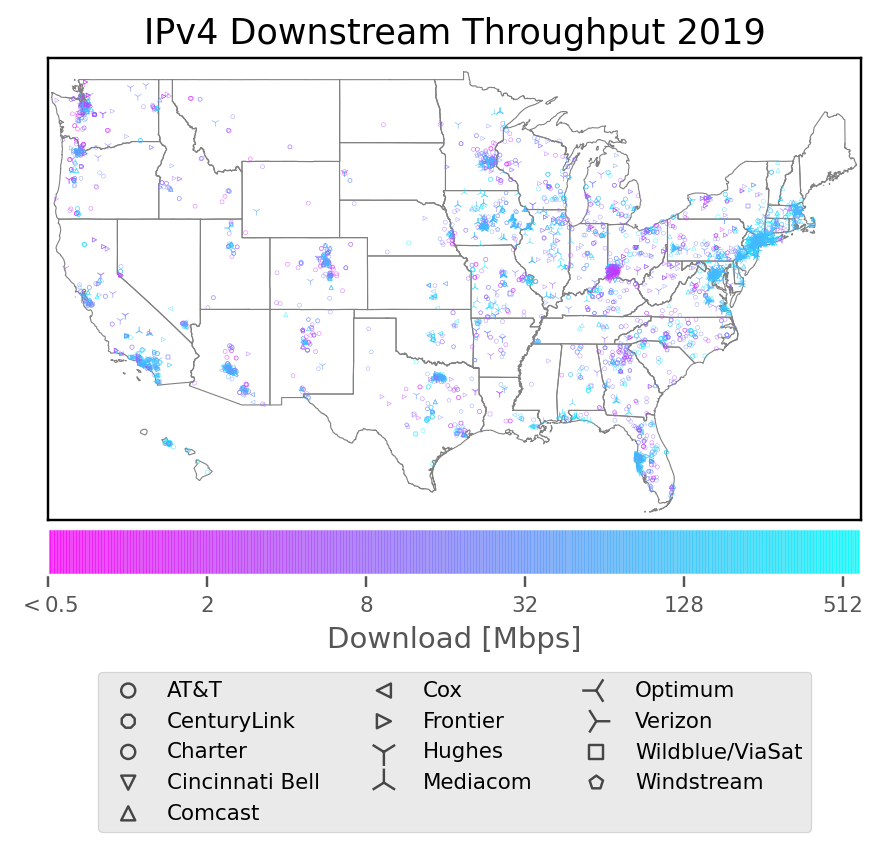

In [115]:
#max_bytes_sec = np.ceil(max(df_6_plt['med_bytes_sec'].max(), df_plt['med_bytes_sec'].max())/100)*100

#https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py
#http://shallowsky.com/blog/programming/plotting-election-data-basemap.html

min_bytes_sec = 0.5
cbar_base = 2
years = [2019]#[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    with plt.style.context(('ggplot')):
        df_plt_tmp = df_plt[(df_plt.year == str(year)) & (df_plt.state != 'HI')].sort_values(['med_bytes_sec'], ascending=False)
        df_plt_tmp_hi = df_plt[(df_plt.year == str(year)) & (df_plt.state == 'HI')].sort_values(['med_bytes_sec'], ascending=False)
        
        max_bytes_sec = np.ceil(df_plt[df_plt.year == str(year)]['med_bytes_sec'].max()/100)*100


        fig = plt.figure(figsize=(6, 6))
        #fig.subplots_adjust(hspace=.3)
        ax = fig.add_subplot(111)
        
        
        
        '''m = Basemap(projection='merc', llcrnrlat=+14.04529,
                    llcrnrlon=-162.82032, urcrnrlat=+52.55921,
                    urcrnrlon=-51.90235, lat_ts=20,
                    resolution='l')#'c'
        m_ = Basemap(llcrnrlon=-162,llcrnrlat=17,urcrnrlon=-152,urcrnrlat=23,
            projection='merc',lat_ts=20, resolution='l')
        
        m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l')'''

        m = Basemap(resolution='l',
                    llcrnrlon = -125, urcrnrlon = -66.6,
                    llcrnrlat = 24, urcrnrlat = 50,
                    projection='merc')
        
        
        
        
        
        #m.fillcontinents(color='white',lake_color='lightcyan', zorder=1)
        m.drawmapboundary(fill_color='white', zorder=0)
        
        #m.drawcoastlines(linewidth=0.15, zorder=2)
        #m.drawcountries(linewidth=0.15, zorder=3)
        
        shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
        #shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)
        
        
        


        ax.set_title('IPv4 Downstream Throughput ' + str(year))
        
        mrk_size = 3
        for isp in sorted(list(df_plt_tmp.isp.unique())):
            lat = df_plt_tmp[df_plt_tmp.isp == isp]['latitude'].values
            lon = df_plt_tmp[df_plt_tmp.isp == isp]['longitude'].values
            bytes_vals = df_plt_tmp[df_plt_tmp.isp == isp]['med_bytes_sec'].values

            im = m.scatter(lon, lat, latlon=True, c=bytes_vals, zorder=10, cmap='cool_r', alpha=0.7, s=mrk_size,
            marker=marker_mapping[isp], norm=mpl.colors.LogNorm(), vmin = min_bytes_sec, vmax=max_bytes_sec, 
            label=isp, linewidths=0.2)#[10 for i in bytes_vals])
            if marker_mapping[isp] in ['1', '2', '3', '4', '+', 'x']:
                im.set_linewidth(0.3)
                im.set_sizes([mrk_size*4])
            if marker_mapping[isp] == '.':
                im.set_sizes([mrk_size*4])
            im.set_facecolor("none")
        
        axins = inset_axes(ax, width="30%", height="20%", loc=3)
        #m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
        #    projection='merc',lat_ts=20,resolution='l', ax=axins)
        m_ = Basemap(llcrnrlon=-162,llcrnrlat=17,urcrnrlon=-152,urcrnrlat=23,
                projection='merc',lat_ts=20, resolution='l', ax=axins)
        m_.fillcontinents(color='white',lake_color='lightcyan', zorder=1)
        m_.drawmapboundary(fill_color='white', zorder=0, linewidth=0.0)
        m_.drawcoastlines(linewidth=0.45, zorder=2, color='gray')
        #m.drawcountries(linewidth=0.15, zorder=3)
        for isp in sorted(list(df_plt_tmp_hi.isp.unique())):
            lat = df_plt_tmp_hi[df_plt_tmp_hi.isp == isp]['latitude'].values
            lon = df_plt_tmp_hi[df_plt_tmp_hi.isp == isp]['longitude'].values
            bytes_vals = df_plt_tmp_hi[df_plt_tmp_hi.isp == isp]['med_bytes_sec'].values

            im = m_.scatter(lon, lat, latlon=True, c=bytes_vals, zorder=10, cmap='cool_r', alpha=0.7, s=mrk_size,
            marker=marker_mapping[isp], norm=mpl.colors.LogNorm(), vmin = min_bytes_sec, vmax=max_bytes_sec, 
            label=isp, linewidths=0.2)#[10 for i in bytes_vals])
            if marker_mapping[isp] in ['1', '2', '3', '4', '+', 'x']:
                im.set_linewidth(0.3)
                im.set_sizes([mrk_size*4])
            if marker_mapping[isp] == '.':
                im.set_sizes([mrk_size*4])
            im.set_facecolor("none")
            
        
        #cb = fig.colorbar(sm, ax=ax, orientation='horizontal')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="10%", pad=0.05)
        
        cb = fig.colorbar(im, ax=ax, orientation="horizontal", cax=cax, label='Download [Mbps]', format=plt.FuncFormatter(lambda x,y: custom_general_format(x)), ticks=ticker.LogLocator(base=cbar_base))
        #plt.clim(0., max_bytes_sec)
        if cbar_base == 2:
            cb.ax.minorticks_off()
        
        leg = ax.legend(loc = 'center', markerscale=10/mrk_size, bbox_to_anchor=(0.5,-0.5), ncol=3)
        for lh in leg.legendHandles:
            lh.set_edgecolor('black')
            lh.set_linewidth(1.0)
        plt.show()
        fig.savefig('HTTP_GET_MT/HTTP-GET-MT-By-Location'+str(year)+'-IPv4-by-ISP.pdf', format='pdf', bbox_inches='tight')